# Fine-tune DenseNet and ResNet

In [3]:
import os
import time
import copy
import json
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import math
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)

# ------------------
# Config (edit these)
# ------------------
DATA_DIR = "/kaggle/input/realwaste/realwaste-main/RealWaste"            # expects train/, val/, test/ inside
RESULTS_DIR = "results"      # where CSVs & metrics will be saved
EPOCHS = 15
BATCH_SIZE = 32
LR = 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 4
RANDOM_SEED = 42
FINETUNE_ALL_LAYERS = True   # True = fine-tune full backbone; False = feature-extract (freeze backbone)

# ------------------
# Reproducibility
# ------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ------------------
# Data
# ------------------
# Standard ImageNet normalization for pre-trained models
img_size = 224
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")


def dir_has_classes(d):
    """Return True if directory exists and contains at least one entry (class subfolder)."""
    return os.path.isdir(d) and any(os.scandir(d))


if dir_has_classes(train_dir) and dir_has_classes(val_dir) and dir_has_classes(test_dir):
    # Use pre-split folders when available
    train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
    val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
    test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)
    class_names = train_ds.classes
else:
    # Single-root dataset (class subfolders inside DATA_DIR).
    # We follow the notebook logic: reproducible shuffle with RANDOM_SEED,
    # create a 70% train / 30% temp split, then split temp into val/test by batches
    # (temp_batches = ceil(0.30 * N / BATCH_SIZE); val = first half batches, test = rest).
    full_ds_for_classes = datasets.ImageFolder(DATA_DIR)
    class_names = full_ds_for_classes.classes
    num_samples = len(full_ds_for_classes)
    if num_samples == 0:
        raise RuntimeError(f"No images found in {DATA_DIR} (expected class subfolders with images)")

    # deterministic shuffle
    idxs = np.arange(num_samples)
    rng = np.random.RandomState(RANDOM_SEED)
    rng.shuffle(idxs)

    # number of batches that would be in the 30% temp split (mimic TF's batch splitting)
    temp_batches = int(math.ceil(0.30 * num_samples / float(BATCH_SIZE)))
    val_batches = temp_batches // 2
    test_batches = temp_batches - val_batches

    val_count = val_batches * BATCH_SIZE
    test_count = test_batches * BATCH_SIZE
    train_count = num_samples - (val_count + test_count)

    # If computed train_count is non-positive (small datasets / large batch size),
    # fall back to exact 70/15/15 sample-level split
    if train_count <= 0:
        train_count = int(np.floor(0.70 * num_samples))
        remaining = num_samples - train_count
        val_count = remaining // 2
        test_count = remaining - val_count

    train_idx = idxs[:train_count].tolist()
    val_idx = idxs[train_count: train_count + val_count].tolist()
    test_idx = idxs[train_count + val_count: train_count + val_count + test_count].tolist()

    # Build datasets (train uses train_tfms, val/test use eval_tfms)
    train_ds_full = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
    eval_ds_full = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)

    train_ds = Subset(train_ds_full, train_idx)
    val_ds   = Subset(eval_ds_full,  val_idx)
    test_ds  = Subset(eval_ds_full,  test_idx)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

num_classes = len(class_names)

# ------------------
# Models
# ------------------
def build_model(model_name: str, num_classes: int, finetune_all: bool = True) -> nn.Module:
    """
    Returns a pre-trained model with the final classifier replaced for num_classes.
    """
    if model_name.lower() in ["resnet50", "resnet-50"]:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)

    elif model_name.lower() in ["densenet121", "dense121", "densenet-121"]:
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        in_feats = model.classifier.in_features
        model.classifier = nn.Linear(in_feats, num_classes)

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    if not finetune_all:
        # Feature extraction mode: freeze the backbone
        for name, param in model.named_parameters():
            param.requires_grad = False
        # Unfreeze classifier head
        if isinstance(model, models.ResNet):
            for param in model.fc.parameters():
                param.requires_grad = True
        else:
            for param in model.classifier.parameters():
                param.requires_grad = True

    return model

# ------------------
# Train / Evaluate
# ------------------
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_correct += torch.sum(preds == labels).item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_correct += torch.sum(preds == labels).item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate_on_test(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(list(preds))
        all_labels.extend(list(labels.numpy()))

    acc = accuracy_score(all_labels, all_preds)
    pr, rc, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, digits=4)
    return {
        "accuracy": acc,
        "precision_weighted": pr,
        "recall_weighted": rc,
        "f1_weighted": f1,
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

def run_training(model_name: str):
    print(f"\n=== Training {model_name} ===")
    model = build_model(model_name, num_classes, finetune_all=FINETUNE_ALL_LAYERS).to(device)

    # Only update params that require grad (supports feature-extract mode)
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params_to_update, lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    best_wts = copy.deepcopy(model.state_dict())
    best_val_acc = -1.0

    history = []
    start_time = time.time()
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history.append({
            "epoch": epoch,
            "train_loss": float(train_loss),
            "train_acc": float(train_acc),
            "val_loss": float(val_loss),
            "val_acc": float(val_acc),
            "epoch_time_sec": float(time.time() - t0),
        })

        # Track best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d}/{EPOCHS} | "
              f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

    # Restore best weights
    model.load_state_dict(best_wts)

    # Test evaluation
    test_metrics = evaluate_on_test(model, test_loader, class_names)

    # Save artifacts
    model_tag = model_name.lower().replace(" ", "_").replace("-", "")
    out_dir = Path(RESULTS_DIR) / model_tag
    out_dir.mkdir(parents=True, exist_ok=True)

    # Per-epoch CSV (covers #16)
    pd.DataFrame(history).to_csv(out_dir / "train_val_history.csv", index=False)

    # Test metrics JSON + text report (covers #17)
    with open(out_dir / "test_metrics.json", "w") as f:
        json.dump(test_metrics, f, indent=2)
    with open(out_dir / "classification_report.txt", "w") as f:
        f.write(test_metrics["classification_report"])

    # Save class index mapping for reproducibility
    with open(out_dir / "class_index.json", "w") as f:
        json.dump({i: c for i, c in enumerate(class_names)}, f, indent=2)

    # Save model weights
    torch.save(model.state_dict(), out_dir / "best_model.pth")

    elapsed = time.time() - start_time
    print(f"\n[{model_name}] Done in {elapsed/60:.1f} min")
    print(f"Best Val Acc: {best_val_acc:.4f}")
    print(f"Test Acc   : {test_metrics['accuracy']:.4f}")
    print(f"Per-epoch log : {out_dir / 'train_val_history.csv'}")
    print(f"Metrics JSON  : {out_dir / 'test_metrics.json'}")
    print(f"Report        : {out_dir / 'classification_report.txt'}")
    return best_val_acc, test_metrics

def main():
    # (13) Choose two SOTA backbones
    models_to_run = ["resnet50", "densenet121"]

    summary = {}
    for m in models_to_run:
        best_val_acc, test_metrics = run_training(m)
        summary[m] = {
            "best_val_acc": float(best_val_acc),
            "test": test_metrics
        }

    # Overall summary
    with open(Path(RESULTS_DIR) / "summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    print("\n=== Summary ===")
    for k, v in summary.items():
        print(f"{k}: best_val_acc={v['best_val_acc']:.4f} | test_acc={v['test']['accuracy']:.4f}")

if __name__ == "__main__":
    main()



=== Training resnet50 ===


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


Epoch 01/15 | train_loss=0.8306 acc=0.7246 | val_loss=0.4251 acc=0.8438
Epoch 02/15 | train_loss=0.3527 acc=0.8789 | val_loss=0.3763 acc=0.8821
Epoch 03/15 | train_loss=0.2343 acc=0.9224 | val_loss=0.4341 acc=0.8736
Epoch 04/15 | train_loss=0.1637 acc=0.9466 | val_loss=0.3360 acc=0.8949
Epoch 05/15 | train_loss=0.1294 acc=0.9601 | val_loss=0.3928 acc=0.8835
Epoch 06/15 | train_loss=0.1117 acc=0.9653 | val_loss=0.3674 acc=0.8977
Epoch 07/15 | train_loss=0.0981 acc=0.9686 | val_loss=0.5145 acc=0.8494
Epoch 08/15 | train_loss=0.0963 acc=0.9668 | val_loss=0.2975 acc=0.9091
Epoch 09/15 | train_loss=0.0829 acc=0.9716 | val_loss=0.4226 acc=0.8977
Epoch 10/15 | train_loss=0.0814 acc=0.9771 | val_loss=0.2939 acc=0.9119
Epoch 11/15 | train_loss=0.0551 acc=0.9810 | val_loss=0.3115 acc=0.9062
Epoch 12/15 | train_loss=0.0560 acc=0.9819 | val_loss=0.3907 acc=0.8991
Epoch 13/15 | train_loss=0.0303 acc=0.9928 | val_loss=0.2923 acc=0.9176
Epoch 14/15 | train_loss=0.0356 acc=0.9885 | val_loss=0.3882 acc

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 81.6MB/s]


Epoch 01/15 | train_loss=0.8191 acc=0.7204 | val_loss=0.5359 acc=0.8011
Epoch 02/15 | train_loss=0.3956 acc=0.8732 | val_loss=0.4759 acc=0.8366
Epoch 03/15 | train_loss=0.2612 acc=0.9170 | val_loss=0.3121 acc=0.9006
Epoch 04/15 | train_loss=0.1760 acc=0.9426 | val_loss=0.3664 acc=0.8949
Epoch 05/15 | train_loss=0.1362 acc=0.9562 | val_loss=0.3812 acc=0.8793
Epoch 06/15 | train_loss=0.1413 acc=0.9568 | val_loss=0.3173 acc=0.8906
Epoch 07/15 | train_loss=0.0898 acc=0.9761 | val_loss=0.3048 acc=0.9134
Epoch 08/15 | train_loss=0.1126 acc=0.9638 | val_loss=0.3028 acc=0.9119
Epoch 09/15 | train_loss=0.0970 acc=0.9677 | val_loss=0.3982 acc=0.8935
Epoch 10/15 | train_loss=0.0547 acc=0.9834 | val_loss=0.3588 acc=0.9034
Epoch 11/15 | train_loss=0.0719 acc=0.9786 | val_loss=0.2908 acc=0.9205
Epoch 12/15 | train_loss=0.0503 acc=0.9831 | val_loss=0.3041 acc=0.9190
Epoch 13/15 | train_loss=0.0636 acc=0.9807 | val_loss=0.3416 acc=0.9091
Epoch 14/15 | train_loss=0.1061 acc=0.9644 | val_loss=0.3073 acc

In [4]:
import json
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("results")  # change if you saved elsewhere

def load_history(model_tag):
    """Load per-epoch CSV for a model (resnet50 or densenet121)."""
    csv_path = BASE / model_tag / "train_val_history.csv"
    return pd.read_csv(csv_path)

def load_metrics(model_tag):
    """Load test_metrics.json for a model."""
    js_path = BASE / model_tag / "test_metrics.json"
    with open(js_path, "r") as f:
        return json.load(f)

def class_names_from_file(model_tag):
    """Fetch class index mapping to get ordered class names (if you saved it)."""
    p = BASE / model_tag / "class_index.json"
    if p.exists():
        with open(p, "r") as f:
            mapping = json.load(f)
        # mapping is like {"0": "cat", "1": "dog"} or {0: "cat", 1: "dog"}
        ordered = [mapping[str(i)] if str(i) in mapping else mapping[i] for i in sorted(map(int, mapping.keys()))]
        return ordered
    return None

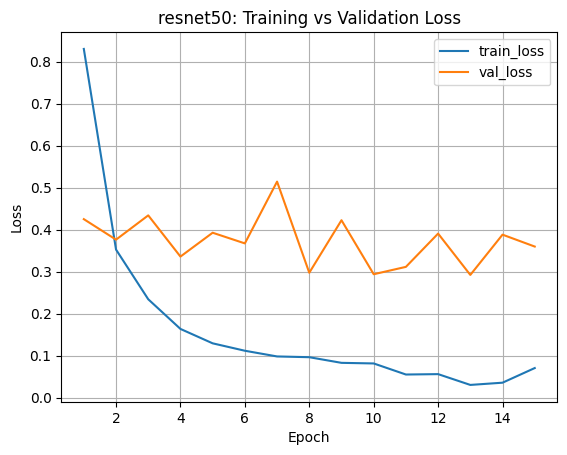

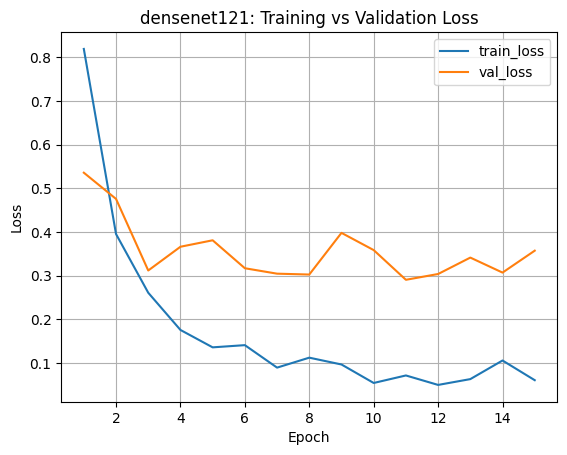

In [5]:
def plot_loss_curves(model_tag):
    df = load_history(model_tag)
    plt.figure()
    plt.plot(df["epoch"], df["train_loss"], label="train_loss")
    plt.plot(df["epoch"], df["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_tag}: Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Examples:
plot_loss_curves("resnet50")
plot_loss_curves("densenet121")

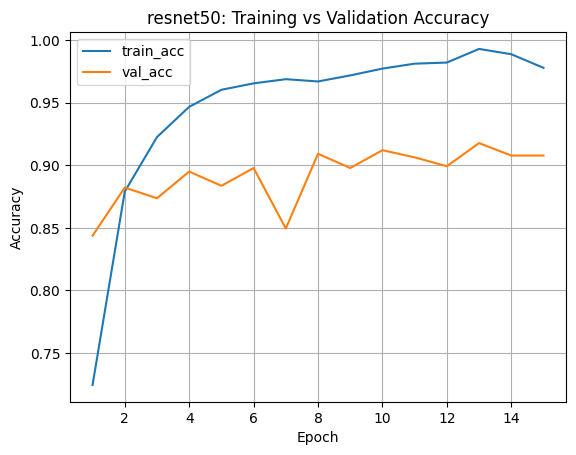

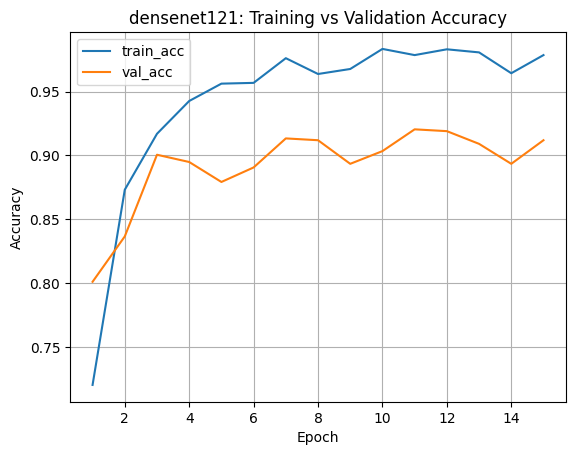

In [6]:
def plot_accuracy_curves(model_tag):
    df = load_history(model_tag)
    plt.figure()
    plt.plot(df["epoch"], df["train_acc"], label="train_acc")
    plt.plot(df["epoch"], df["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_tag}: Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Examples:
plot_accuracy_curves("resnet50")
plot_accuracy_curves("densenet121")


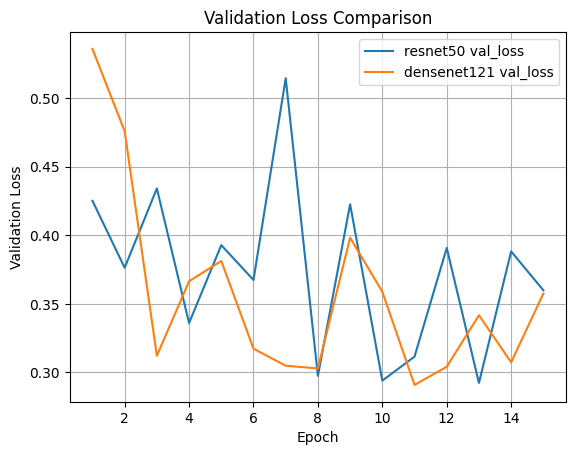

In [7]:
def compare_val_loss(models=("resnet50","densenet121")):
    plt.figure()
    for m in models:
        df = load_history(m)
        plt.plot(df["epoch"], df["val_loss"], label=f"{m} val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_val_loss(("resnet50","densenet121"))


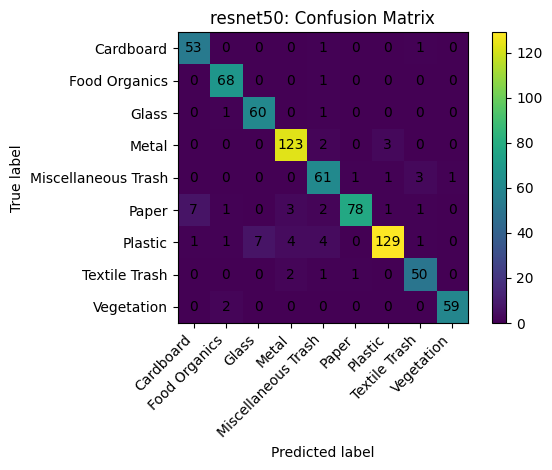

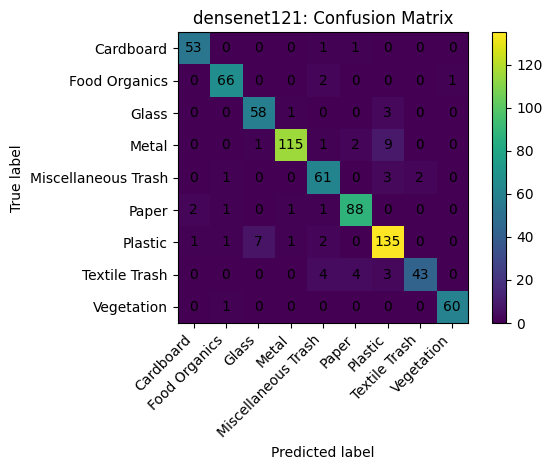

In [8]:
def plot_confusion_matrix(model_tag):
    metrics = load_metrics(model_tag)
    cm = np.array(metrics["confusion_matrix"])
    classes = class_names_from_file(model_tag)
    if classes is None:
        classes = [f"C{i}" for i in range(cm.shape[0])]

    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{model_tag}: Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    # annotate cells
    thresh = cm.max() / 2.0 if cm.size > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

# Examples:
plot_confusion_matrix("resnet50")
plot_confusion_matrix("densenet121")


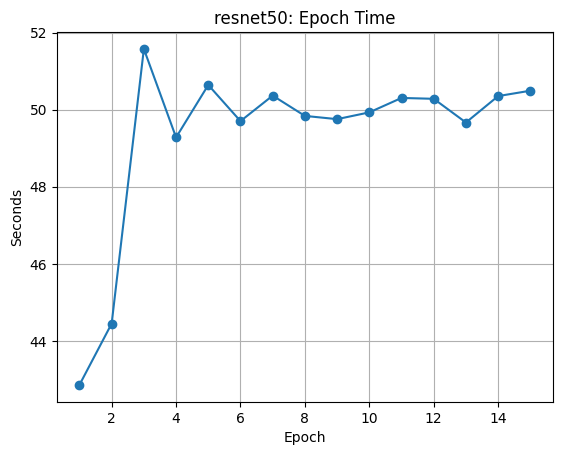

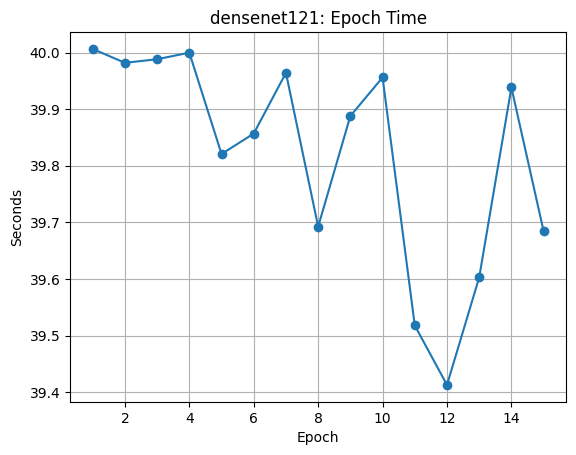

In [9]:
def plot_epoch_time(model_tag):
    df = load_history(model_tag)
    plt.figure()
    plt.plot(df["epoch"], df["epoch_time_sec"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title(f"{model_tag}: Epoch Time")
    plt.grid(True)
    plt.show()

plot_epoch_time("resnet50")
plot_epoch_time("densenet121")
